In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def import_survival_data(filepath):
    df = pd.read_csv(filepath, sep=',', header=0, names=['Time', 'Survival'])
    df.loc[:, 'Survival'] = df['Survival']
    df = df.drop_duplicates()
    return df

In [3]:
def _comb_prob(p_high, p_low, rho):
    return p_high + ((1 - p_high) * p_low * (1 - rho))

In [4]:
def combined_prob(f_a, f_b, timecourse, rho=0.3):
    prob_a, prob_b = f_a(timecourse), f_b(timecourse)
    return _comb_prob(np.fmax(prob_a, prob_b), np.fmin(prob_a, prob_b), rho)

In [5]:
def interpolate(df, kind='linear'):
    return interp1d(df['Time'], df['Survival'], kind=kind, fill_value='extrapolate')

In [86]:
# import data
treat_a = import_survival_data('../data/NSNSCLC_chemo_Socinski2018.csv')
treat_b = import_survival_data('../data/NSNSCLC_atezo_Rittmeyer2017.csv')
treat_a_b = import_survival_data('../data/NSNSCLC_atezo_chemo_Socinski2018.csv')

In [97]:
# interpolate
f_a = interpolate(treat_a)
f_b = interpolate(treat_b)

In [139]:
timepoints = np.arange(0, int(min(treat_a['Time'].max(), treat_b['Time'].max())), 0.01)

In [142]:
predicted = pd.DataFrame({"Time": timepoints,
                          "Survival": combined_prob(f_a, f_b, timepoints, rho=0.3)})

(0, 1.0495019623160935)

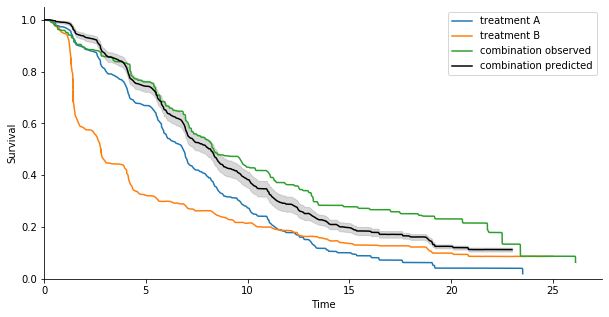

In [143]:
# draw survival curves
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine()
sns.lineplot(x='Time', y='Survival', data=treat_a, 
             label='treatment A', ax=ax)
sns.lineplot(x='Time', y='Survival', data=treat_b, 
             label='treatment B', ax=ax)
sns.lineplot(x='Time', y='Survival', data=treat_a_b, 
             label='combination observed', ax=ax)
sns.lineplot(x='Time', y='Survival', data=predicted, 
             color='black', label='combination predicted', ax=ax)
ax.fill_between(timepoints, 
                combined_prob(f_a, f_b, timepoints, rho=0.1), 
                combined_prob(f_a, f_b, timepoints, rho=0.5),
                alpha=0.3, color='gray')
ax.set_xlim(0)
ax.set_ylim(0)
#ax.hlines(0.5, xmin=0, xmax=15, color='black', linestyle='--')

#fig.savefig('../analysis/a_b_survival.pdf')

(0, 104.60625807881065)

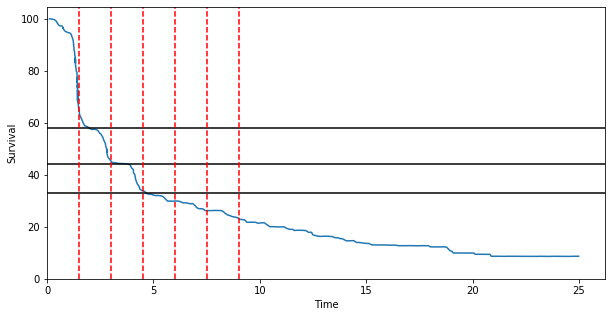

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='Time', y='Survival', data=treat_b, ax=ax)
ax.axhline(58, color='black')
ax.axhline(44, color='black')
ax.axhline(33, color='black')
for i in range(1, 7):
    ax.axvline(1.5 * i, color='red', linestyle='--')
ax.set_xlim(0)
ax.set_ylim(0)

In [87]:
treat_b.index = treat_b.index + 1
treat_b.loc[0, :] = [treat_b.at[1, 'Time'], 0]

In [90]:
treat_b = treat_b.sort_index()

In [98]:
cutoff_idx = treat_b[treat_b['Time'] < 3]['Survival'].idxmin()
respond = treat_b.iloc[:cutoff_idx, :].copy()
nonrespond = treat_b.iloc[cutoff_idx:, :].copy()

respond.loc[:, 'Survival'] = np.interp(respond['Survival'],
                                       (respond['Survival'].min(), respond['Survival'].max()),
                                       (0, 90))
nonrespond.loc[:, 'Survival'] = np.interp(nonrespond['Survival'], 
                                          (nonrespond['Survival'].min(), nonrespond['Survival'].max()), 
                                          (90, 100))

new_df = respond.append(nonrespond)


In [99]:
treat_b.iloc[cutoff_idx, :]

Time         2.929804
Survival    46.151287
Name: 1647, dtype: float64

(0, 105.03685289391001)

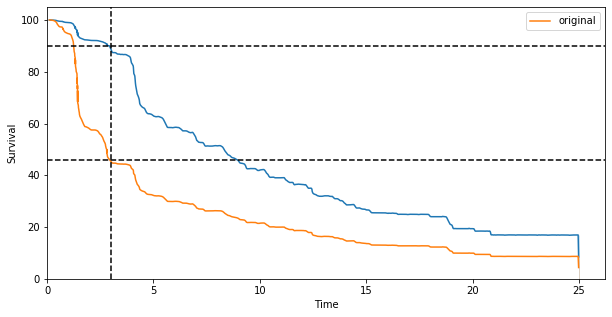

In [100]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='Time', y='Survival', data=new_df, ax=ax)
sns.lineplot(x='Time', y='Survival', data=treat_b, ax=ax, label='original')
ax.axhline(46, color='black', linestyle='--')
ax.axhline(90, color='black', linestyle='--')
ax.axvline(1.5 * 2, color='black', linestyle='--')
ax.set_xlim(0)
ax.set_ylim(0)

In [102]:
a = None
if a:
    print('hi')